# **Laboratorio 4: Detector de Bordes Canny**

En el laboratorio anterior aplicaste filtros de paso alto para acentuar características en una imagen o encontrar sus bordes. Esta vez, aplicaremos filtros de paso bajo que te permitirán suavizar la imagen para minimizar los elementos de alta frecuencia. En este laboratorio, trabajaras principalmente con imágenes ruidosas ya que estas implican desafíos al momento de mejorarlas. A continuación, veras la combinación de filtros de paso bajo y alto integrados al método de detección de bordes Canny. 

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from skimage.util import random_noise

import cv2
import numpy as np

Definiendo una función para mostrar rapidamente las imagenes

In [4]:
def myImages(title1, img1, title2, img2):
  fig = plt.figure(figsize=(20,15))
  ax1 = plt.subplot(1, 2, 1)
  ax2 = plt.subplot(1, 2, 2)
  ax1.set_title(title1)
  ax1.imshow(img1, cmap='gray')
  ax2.set_title(title2)
  ax2.imshow(img2, cmap='gray')
  fig.tight_layout()
  plt.show()

Definiendo una función para mostrar mejor las imagenes

## **Ejercicio 1:** Filtros de paso bajo
Cuanto más reciente sea el método, mejores serán los resultados del filtrado de paso bajo. Ahora, es tu turno de implementar los siguientes filtros desde cero. Para este ejercicio, puedes utilizar la función de filtrado que creaste en el último laboratorio.

- Filtro de la media
- Filtro de la mediana 
- Filtro gaussiano (puedes usar kernels con valores constantes)

Para probar tus metodos, deberas utiizar imágenes con ruido en escala de grises.

Cargando la imagen y agregando ruido gaussiano

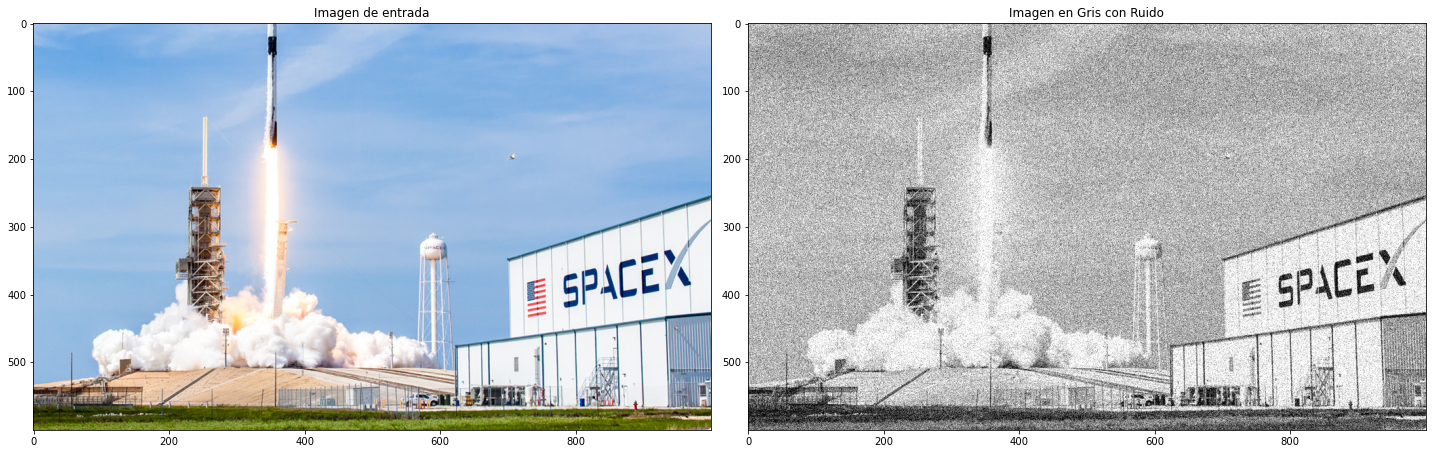

In [5]:
imgBGR = cv2.imread("SpaceX.jpg")
imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)
imgGRAY = cv2.cvtColor(imgBGR, cv2.COLOR_BGRA2GRAY)
img = random_noise(imgGRAY, mode='gaussian',var=0.02)

myImages("Imagen de entrada", imgRGB, "Imagen en Gris con Ruido", img)

### FILTRO DE LA MEDIA

Definir la función para aplicar el filtro de la media:

$H(x,y) = I(x,y)*G(x,y) = \displaystyle\sum_{i=0}^{M_i -1}\sum_{j=0}^{M_j -1} I_{(x+i-a_i , y+j-a_j )}G_{(i,j)}$ 

In [6]:
def convolution(I, G):
  # Dimensiones de la imagen de entrada y del kernel
  iH, iW = I.shape[:2]
  gH, gW = G.shape[:2]
  # Calculo del padding
  padding = int((gW-1)/2)
  # Nueva imagen con padding
  Iwb = cv2.copyMakeBorder(I, padding, padding, padding, padding, cv2.BORDER_CONSTANT)
  # Matriz de ceros de la imagen convolucionada
  H = np.zeros((iH, iW), dtype="float")
  # Proceso de calculo de convolución
  for y in np.arange(padding, iH+padding):
    for x in np.arange(padding, iW+padding):
      roi = Iwb[y-padding : y+padding+1, x-padding : x+padding+1]
      h = (roi * G).sum()
      H[y-padding, x-padding] = h
  # Retorna una imagen convolucionada
  eMax = np.max(H)
  H = H*255/eMax
  H = H.astype("uint8")
  return H

Aplicando el filtro de la media

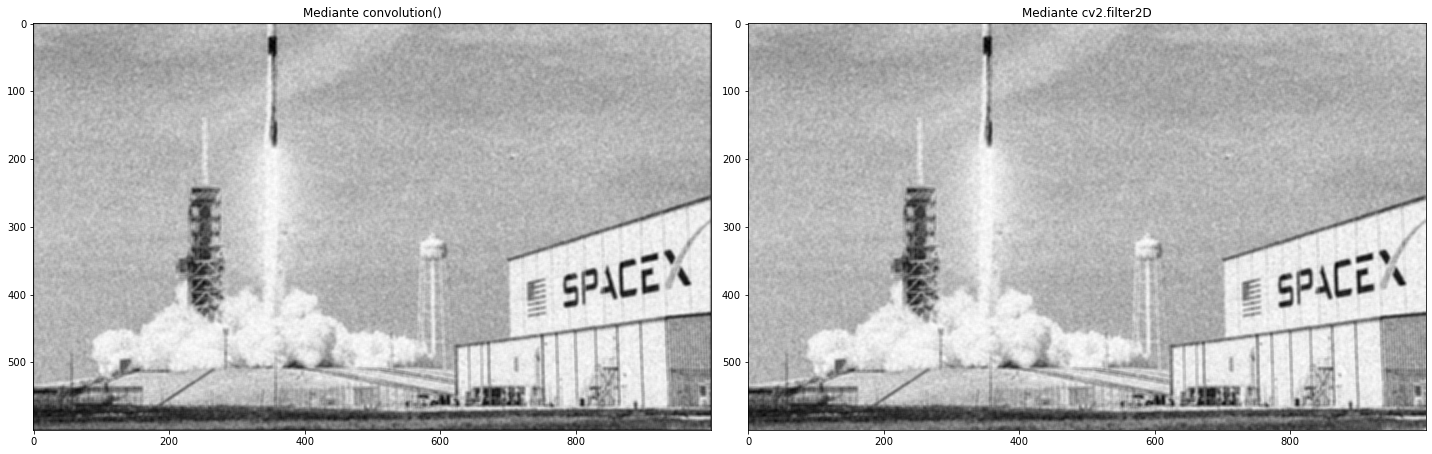

In [7]:
# Crear el filtro de la media
num_rows, num_cols = 5 , 5
total = num_rows*num_cols
kernel = np.ones((num_rows,num_cols),np.float32)/total

# Aplicar el filtro a la imagen en gris con ruido mediante la función definida 
imgConv_1 = convolution(img, kernel)
# Aplicar el filtro a la imagen en gris con ruido mediante cv2.filter2D 
imgCV2_1 = cv2.filter2D(img, -1, kernel)
# Comparar ambos resultados
myImages("Mediante convolution()", imgConv_1, "Mediante cv2.filter2D", imgCV2_1)

### FILTRO DE LA MEDIANA

Definir la función para aplicar el filtro de la mediana:

In [8]:
# El tamaño del kernel debe ser un número entero impar positivo.
def mediana(I, G):
  # Dimensiones de la imagen de entrada y del kernel
  iH, iW = I.shape[:2]
  gH, gW = G, G
  # Calculo del padding
  padding = int((gW-1)/2)
  # Nueva imagen con padding
  Iwb = cv2.copyMakeBorder(I, padding, padding, padding, padding, cv2.BORDER_REPLICATE)
  # Matriz de ceros de la imagen convolucionada
  H = np.zeros((iH, iW), dtype="float")
  # Proceso de calculo de convolución
  for y in np.arange(padding, iH+padding):
    for x in np.arange(padding, iW+padding):
      roi = Iwb[y-padding : y+padding+1, x-padding : x+padding+1]
      h = np.median(roi)
      H[y-padding, x-padding] = h
  # Retorna una imagen convolucionada
  eMax = np.max(H)
  # Para obtener los mismos resultados que cv2.medianBlur no escalaremos la salida
  # H = H*255/eMax
  # H = H.astype("uint8")
  return H

Aplicando el filtro de la mediana

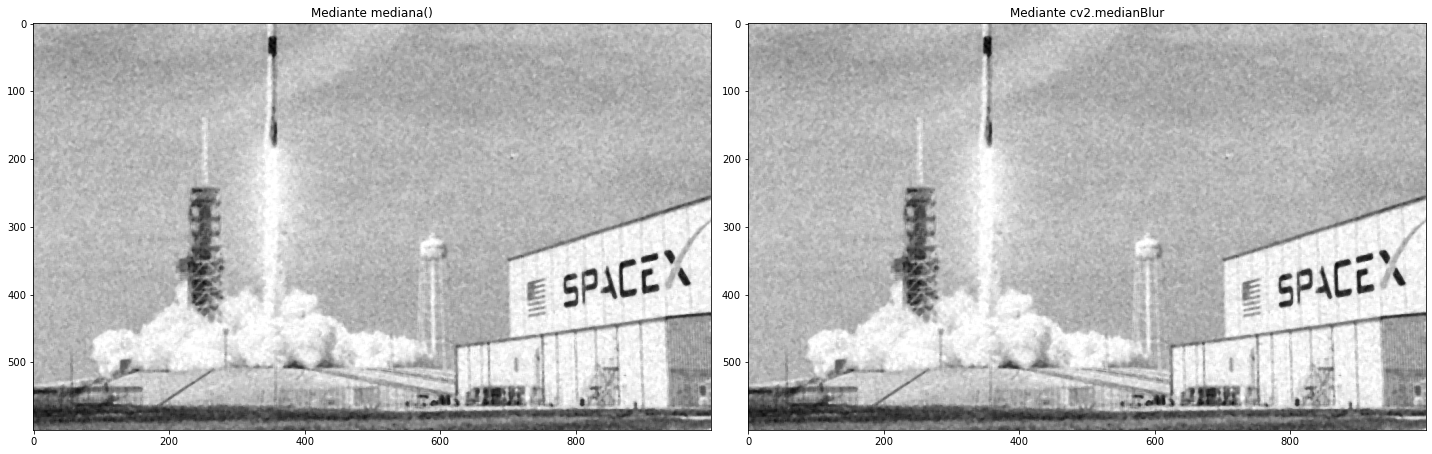

In [9]:
# Aplicar el filtro a la imagen en gris con ruido mediante la función definida 
imgConv_2 = mediana(img, 5)
# Aplicar el filtro a la imagen en gris con ruido mediante cv2.medianBlur 
imgCV2_2 = cv2.medianBlur(np.float32(img),5)
# Comparar ambos resultados
myImages("Mediante mediana()", imgConv_2, "Mediante cv2.medianBlur", imgCV2_2)
# print("imgConv_2\n", imgConv_2)
# print("imgCV2_2\n", imgCV2_2)

## **Ejercicio 2:** Procesamiento de Imágenes Médicas

Un médico diagnosticó a un paciente con un tumor benigno, el cual requiria una cirugía urgente para evitar que empeorara. Después, la cirugía se completó con éxito y se le solicitó al paciente que se realizara exámenes de tomografía computarizada todos los meses. El primer examen estuvo bien pero, lamentablemente, el equipo de análisis de imágenes computarizado se averio.

¿Puedes darles una mano?
Limpia la imagen y detecta los bordes. Al final, deberías obtener dos imagenes separadas, una con el examen anterior y otra imagen con el nuevo examen. Ambas imágenes deben estar binarizadas y solo con bordes.

No es necesario que diagnostiques la imagen todavía (es decir, identificar automáticamente si el paciente ha mejorado), pero puedes ayudar mostrando la ubicación del tumor en la muestra anterior. **Pista:** Puede usar cv.rectangle() o cv.circle() para marcar rectángulos y círculos en una imagen, respectivamente.

Deberas trabajar con la siguiente imagen: https://drive.google.com/file/d/1pV8_cUtI70tNNTL-o-ZPyK-tU0fOwv3t/view?usp=sharing 

In [10]:
# Lectura de la imagen
image = cv2.imread('CT benign tumor.png',0)

In [11]:
# Aplicar filtro gaussiano con desviación estándar = 0
#kernel_size = 1
# parámetros: imagen, dimensiones del núcleo, sigma x, sigma y
#image = cv2.GaussianBlur(image,(kernel_size,kernel_size),0,0)

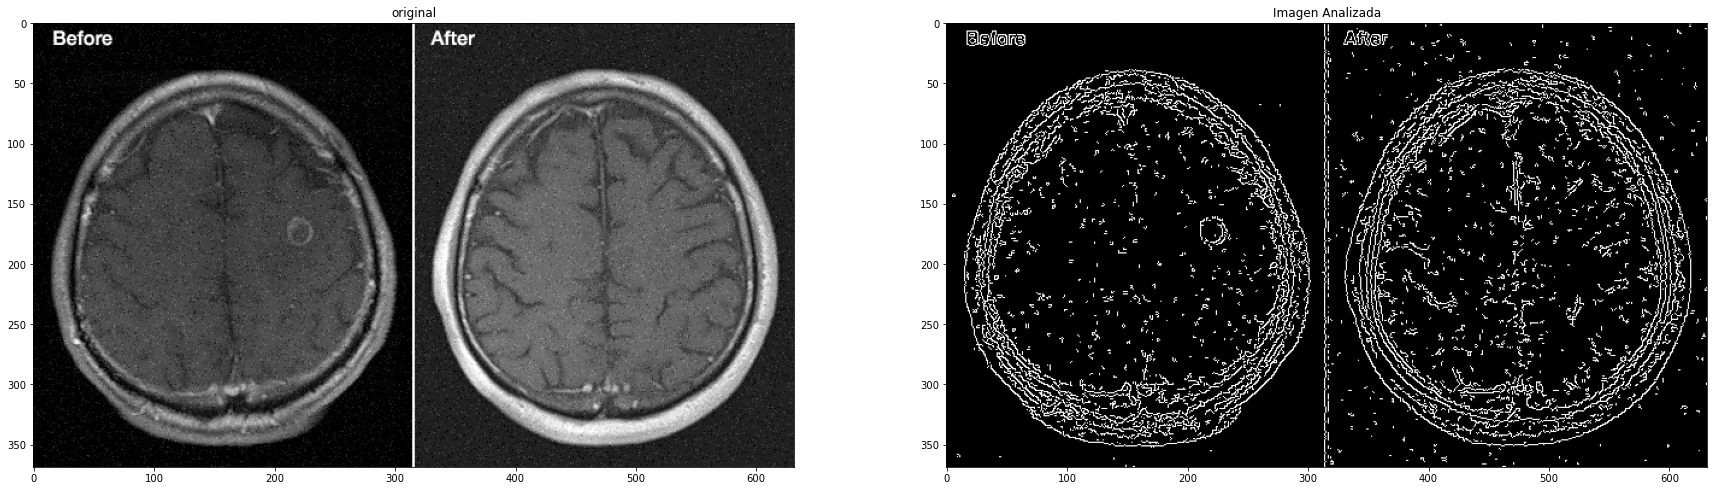

In [12]:
# Aplicar Canny usando umbrales amplios y estrechos

analized = cv2.Canny(image, 120, 185)
    
# Mostrar resultados
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,15))

ax1.set_title('original')
ax1.imshow(image, cmap='gray')

ax2.set_title('Imagen Analizada')
ax2.imshow(analized, cmap='gray')

In [13]:
#(contornos,_) = cv2.findContours(analized.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [14]:
#cv2.drawContours(image,contornos,-1,(255,255,255), 2)
#cv2.imshow("contornos", image)

#cv2.waitKey(0)

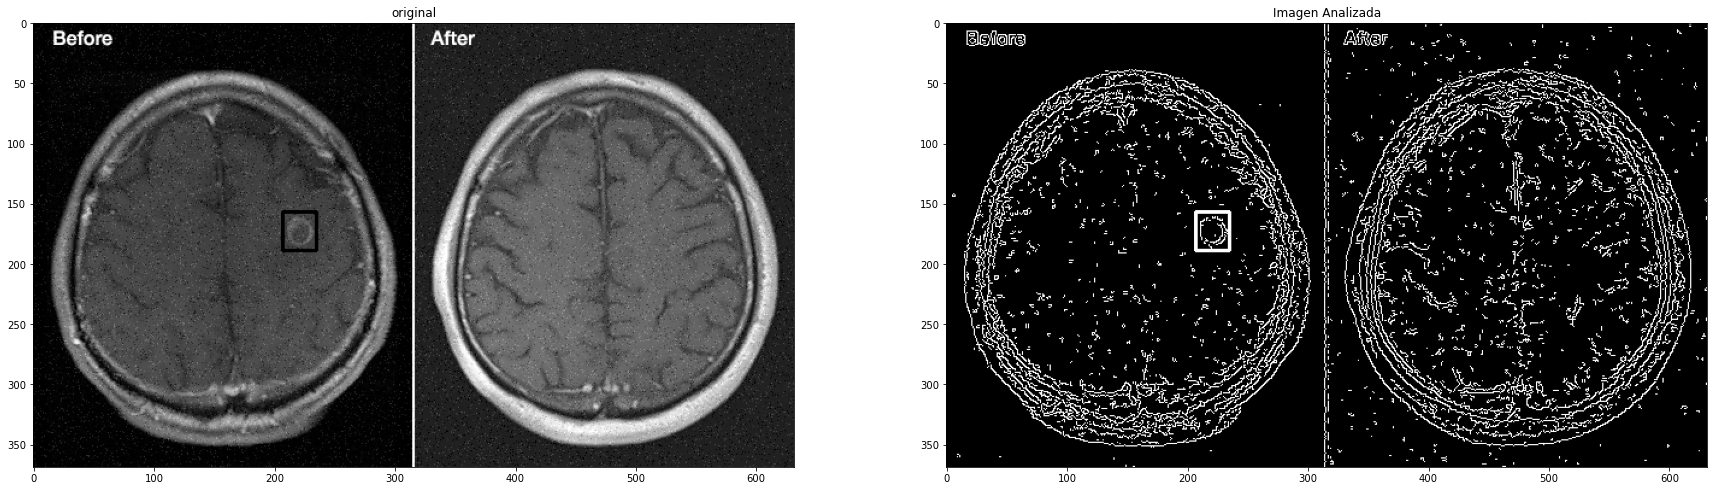

In [15]:
ptLeftTop = (207, 157)  # (Esquina superior izquierda x, esquina superior izquierda y)
ptRightBottom = (235, 189) # (Esquina inferior derecha x, esquina inferior derecha y)
point_color0 = (0, 0 , 0)  # Color de caja RGB, personalizado
point_color1 = (255, 255, 255)  # Color de caja RGB, personalizado
thickness = 2
lineType = 4
cv2.rectangle(image, ptLeftTop, ptRightBottom, point_color0, thickness, lineType)
cv2.rectangle(analized, ptLeftTop, ptRightBottom, point_color1, thickness, lineType)

# Mostrar resultados
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,15))

ax1.set_title('original')
ax1.imshow(image, cmap='gray')

ax2.set_title('Imagen Analizada')
ax2.imshow(analized, cmap='gray')


## **Ejercicio 3:** Encuentra las gradientes

Encontrar las gradientes (bordes de una imagen) es un paso esencial del detector Canny. En este ejercicio deberas procesar una imagen y encontrar la magnitud y orientación de la gradiente por cada pixel. Tu método debería devolver dos imágenes resultantes (similares a la imagen ejemplo) despues de extraer las gradientes. Finalmente, deberas encontrar, filtrar y mostrar a todos los gradientes que esten apuntando al norte en una tercera imagen.